In [1]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [2]:
# loading the directories
training_dir = '/content/drive/MyDrive/Colab/Data/train_valid_test_1/train/'
validation_dir = '/content/drive/MyDrive/Colab/Data/train_valid_test_1/valid/'
test_dir = '/content/drive/MyDrive/Colab/Data/train_valid_test_1/test/'

In [5]:
# useful for getting number of files
image_files = glob(training_dir + '/*/*.jp*g')
valid_image_files = glob(validation_dir + '/*/*.jp*g')
test_images_files = glob(test_dir + '/*/*.jp*g')

In [4]:
# getting the number of classes i.e. type of fruits
folders = glob(training_dir + '/*')
num_classes = len(folders)
print ('Total Classes = ' + str(num_classes))

Total Classes = 3


In [6]:
# importing the libraries
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import VGG19
#from keras.preprocessing import image

IMAGE_SIZE = [224, 224]  # we will keep the image size as (64,64). You can increase the size for better results.

# loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
vgg = VGG19(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

# this will exclude the initial layers from training phase as there are already been trained.
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
#x = Dense(128, activation = 'relu')(x)   # we can add a new fully connected layer but it will increase the execution time.
# num_classes = 3   # B2, B5, B6
x = Dense(num_classes, activation = 'softmax')(x)  # adding the output layer with softmax function as this is a multi label classification problem.

model = Model(inputs = vgg.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
# Image Augmentation

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

IMAGE_SIZE = [224, 224]

training_datagen = ImageDataGenerator(
                                    rescale=1./255,   # all pixel values will be between 0 an 1
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)

training_generator = training_datagen.flow_from_directory(training_dir, target_size = IMAGE_SIZE, batch_size = 64, class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size = IMAGE_SIZE, batch_size = 64, class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size = IMAGE_SIZE, batch_size = 64, class_mode = 'categorical')


Found 4537 images belonging to 3 classes.
Found 377 images belonging to 3 classes.
Found 568 images belonging to 3 classes.


In [9]:
# The labels are stored in class_indices in dictionary form.
# checking the labels
training_generator.class_indices

{'B2': 0, 'B5': 1, 'B6': 2}

Đoạn code dưới đây dùng để train lại model mình đã train trước đó

In [ ]:
from keras.models import load_model

# Tải mô hình đã lưu
# model = load_model('/content/drive/MyDrive/Colab/Model/model_epoch_04_val_accuracy_0.80.keras')

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab/Model/model_epoch_3_23032024_{epoch:02d}_accuracy_{accuracy:.2f}_val_accuracy_{val_accuracy:.2f}.keras', save_freq='epoch')

In [11]:
history = model.fit(training_generator,
          epochs=7,
          validation_data=validation_generator,
          callbacks=[checkpoint])

Epoch 1/7
71/71 [==============================] - 3525s 49s/step - loss: 0.7264 - accuracy: 0.7485 - val_loss: 0.6488 - val_accuracy: 0.6844
Epoch 2/7
71/71 [==============================] - 3521s 50s/step - loss: 0.3994 - accuracy: 0.8279 - val_loss: 0.5591 - val_accuracy: 0.7480
Epoch 3/7
71/71 [==============================] - 3423s 48s/step - loss: 0.3677 - accuracy: 0.8470 - val_loss: 0.5633 - val_accuracy: 0.7401
Epoch 4/7
71/71 [==============================] - 3409s 48s/step - loss: 0.3292 - accuracy: 0.8614 - val_loss: 0.6400 - val_accuracy: 0.7321
Epoch 5/7
71/71 [==============================] - 3436s 48s/step - loss: 0.3183 - accuracy: 0.8627 - val_loss: 0.5433 - val_accuracy: 0.7401
Epoch 6/7
71/71 [==============================] - 3419s 48s/step - loss: 0.3298 - accuracy: 0.8581 - val_loss: 0.5980 - val_accuracy: 0.7454
Epoch 7/7
71/71 [==============================] - 3408s 48s/step - loss: 0.3096 - accuracy: 0.8667 - val_loss: 0.5424 - val_accuracy: 0.7586


In [ ]:
# Lưu mô hình cùng với trạng thái của trình tối ưu hóa
model.save('/content/drive/MyDrive/Colab/Model/vgg16_model_1.keras')

In [12]:
# In độ chính xác đào tạo và xác thực
# Đây là kết quả 2 lần epoch đầu tiên:
# Training Accuracy = [0.7166796326637268, 0.7898155450820923]
# Validation Accuracy = [0.7809224128723145, 0.6855345964431763]
print('Training Accuracy = ' + str(history.history['accuracy']))
print('Validation Accuracy = ' + str(history.history['val_accuracy']))

Training Accuracy = [0.7485122084617615, 0.8278598189353943, 0.8470354676246643, 0.8613621592521667, 0.8626846075057983, 0.8580560088157654, 0.8666519522666931]
Validation Accuracy = [0.6843501329421997, 0.7480106353759766, 0.7400530576705933, 0.73209547996521, 0.7400530576705933, 0.7453581094741821, 0.7586206793785095]


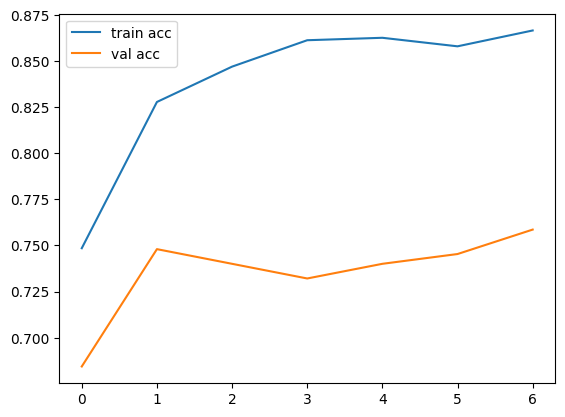

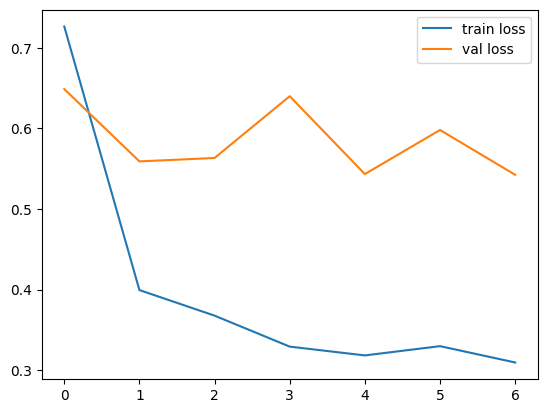

In [13]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()

# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [ ]:
from keras.models import load_model

# Tải mô hình đã lưu
# model = load_model('/content/drive/MyDrive/Colab/Model/vgg16_model_1.keras')
model = load_model('/content/drive/MyDrive/Colab/Model/model_epoch_2_07_val_accuracy_0.77.keras')

In [14]:
x_test=[]
test_path = '/content/drive/MyDrive/Colab/Data/train_valid_test/test'

import os, cv2
import numpy as np
for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        img_arr=img_arr/255.0
        x_test.append(img_arr)

test_x=np.array(x_test)

from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
test_y=test_set.classes

Found 1491 images belonging to 3 classes.


In [15]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

#predict
y_pred=model.predict(test_x)

47/47 [==============================] - 1024s 22s/step


In [16]:
y_pred_=np.argmax(y_pred, axis=1)

In [17]:
print(y_pred.shape, y_pred_.shape, test_y.shape)

(1491, 3) (1491,) (1491,)


In [18]:
print(y_pred_[:50])
print(test_y[:50])

[1 1 1 1 1 1 1 1 0 2 2 2 2 1 2 1 1 1 1 2 2 2 2 1 2 2 1 1 2 1 1 2 1 1 1 1 1
 1 1 2 1 1 2 2 2 2 2 1 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [19]:
#get classification report
print(classification_report(y_pred_, test_y))

#get confusion matrix
print(confusion_matrix(y_pred_, test_y))

              precision    recall  f1-score   support

           0       0.02      0.02      0.02       412
           1       0.08      0.12      0.09       330
           2       0.87      0.57      0.69       749

    accuracy                           0.32      1491
   macro avg       0.32      0.24      0.27      1491
weighted avg       0.46      0.32      0.37      1491

[[  8 400   4]
 [228  39  63]
 [261  58 430]]


In [ ]:
# import cv2
# # Tải ảnh vào một mảng NumPy
# # image = cv2.imread('/content/drive/MyDrive/Colab/Data/train_valid_test/test/B5/B5_0_z5021000001378_1e7342c46548eb446b5a389f07bf35d1.jpg')
# image = cv2.imread('/content/drive/MyDrive/Colab/Data/train_valid_test/test/B6/B6_4_Image_142030.jpg')
# image = cv2.resize(image, (224, 224))

# # Chuẩn hóa ảnh
# image = image / 255.0

# # Thêm một chiều lô vào ảnh
# image = np.expand_dims(image, axis=0)

# # Dự đoán trên ảnh
# predictions = model.predict(image)

# # In các xác suất cho mỗi lớp
# print(predictions)